<h1 style="padding: 8px;color:white; display:fill;background-color:#4683B7; border-radius:6px; font-size:300%"><b> Introduction aux réseaux de neurones</b></h1>

### Réalisé par : GHALIM Nidal | HAMID Hajar | LAHOUIRI Hayat | NACIRI Nacira

### Encadré par : Mr KHALFI

In [23]:
#Importation des bibliothèques
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split

### 2.1 Forward et backward manuels

### La fonction init_params(nx, nh, ny) :

La fonction init_params initialise les poids (Wx et Wy) et les biais bx et by) d'un réseau de neurones à l'aide d'une distribution normale avec une moyenne de zéro et un écart-type de 0.3.

Les poids sont initialisés avec des valeurs aléatoires, tandis que les biais sont initialisés à zéro. Les paramètres sont stockés dans un dictionnaire params.

In [27]:
def init_params(nx, nh, ny):
    # Initialisation des paramètres du réseau de neurones

    # Initialisation des poids de la couche d'entrée vers la couche cachée (Wx)
    Wx = torch.randn(nh, nx) * 0.3
    # Initialisation des biais de la couche cachée (bx)
    bx = torch.zeros(nh, 1)
    # Initialisation des poids de la couche cachée vers la couche de sortie (Wy)
    Wy = torch.randn(ny, nh) * 0.3
    # Initialisation des biais de la couche de sortie (by)
    by = torch.zeros(ny, 1)
    # Stockage des poids et des biais dans un dictionnaire params
    params = {
        'Wx': Wx,
        'bx': bx,
        'Wy': Wy,
        'by': by
    }
    return params


### La fonction forward(params, X) :

Cette fonction forward effectue la propagation avant dans un réseau de neurones en calculant les étapes intermédiaires telles que les activations de la couche d'entrée (Zx) et de la couche cachée (Ax) en utilisant la fonction tangente hyperbolique (tanh). 

Ensuite, elle calcule l'activation de la couche de sortie (Zy) et la sortie prédite (Yhat) en appliquant une fonction softmax pour la classification. Les résultats intermédiaires sont stockés dans un dictionnaire outputs, et la fonction renvoie à la fois ces étapes intermédiaires et la prédiction finale du réseau.

In [28]:
def forward(params, X):
    # Initialisation d'un dictionnaire pour stocker les étapes intermédiaires
    outputs = {}

    # Calcul de l'activation de la couche d'entrée (Zx)
    outputs['Zx'] = torch.mm(params['Wx'], X) + params['bx']

    # Application de la fonction d'activation tanh pour la couche d'entrée (Ax)
    outputs['Ax'] = torch.tanh(outputs['Zx'])

    # Calcul de l'activation de la couche de sortie (Zy)
    outputs['Zy'] = torch.mm(params['Wy'], outputs['Ax']) + params['by']

    # Calcul de la sortie du réseau (Yhat) en appliquant une fonction softmax
    outputs['Yhat'] = torch.exp(outputs['Zy']) / torch.sum(torch.exp(outputs['Zy']), dim=0, keepdim=True)

    # Retourne à la fois les étapes intermédiaires et la sortie prédite (Yhat)
    return outputs, outputs['Yhat']


### La fonction loss_accuracy(Yhat, Y) :

La fonction loss_accuracy calcule à la fois la perte (loss) et la précision (taux de bonnes prédictions) d'un modèle de classification par rapport aux étiquettes réelles.  

Elle calcule la perte en utilisant l'entropie croisée moyenne entre les prédictions du modèle (Yhat) et les étiquettes réelles (Y).

Ensuite, elle détermine l'indice de la classe réelle pour chaque exemple dans Y et l'indice de la classe prédite pour chaque exemple dans Yhat.

La précision est calculée en comparant les indices réels et prédits, puis en comptant combien d'entre eux sont identiques.

La fonction retourne à la fois la perte (L), qui mesure la qualité des prédictions du modèle, et la précision (acc), qui indique le pourcentage d'exemples correctement classés par le modèle.

In [29]:
def loss_accuracy(Yhat, Y):
    """ Calcul de la perte (loss) en utilisant l'entropie croisée moyenne
     Applique la fonction log à Yhat, puis multiplie élément par élément avec Y,
     somme les colonnes (dim=0) pour obtenir la perte pour chaque exemple,
     et calcule la moyenne de ces pertes."""
    L = -torch.mean(torch.sum(Y * torch.log(Yhat), dim=0, keepdim=True))

    # Trouve l'indice de la classe réelle pour chaque exemple dans Y
    _, indsY = torch.max(Y, 1)
    # Trouve l'indice de la classe prédite pour chaque exemple dans Yhat
    _, indsYhat = torch.max(Yhat, 1)
    # Calcule la précision en comparant les indices réels et prédits,
    # compte combien d'entre eux sont identiques, puis divise par le nombre d'exemples.
    acc = torch.sum(indsY == indsYhat) / Y.shape[1]

    # Retourne la perte (L) et la précision (acc)
    return L, acc



### La fonction backward(params, outputs, Y) :

La fonction backward calcule les gradients des paramètres du réseau en utilisant la rétropropagation.Elle prend en entrée trois arguments : params (un dictionnaire contenant les paramètres du réseau, tels que les poids et les biais), outputs (un dictionnaire contenant les sorties intermédiaires du réseau calculées lors de la propagation avant) et Y (les étiquettes réelles).

Elle commence par calculer le gradient de la couche de sortie (dZy), qui mesure comment la perte varie en fonction des sorties de la couche de sortie.

Ensuite, elle calcule le gradient de la perte par rapport aux poids et aux biais de la couche de sortie (dWy et dby) en utilisant dZy.

Elle continue la rétropropagation en calculant le gradient de la couche cachée par rapport à ses entrées pondérées (dZx) en utilisant la dérivée de la fonction d'activation tangente hyperbolique (tanh).

Puis, elle calcule les gradients des poids et des biais de la couche d'entrée (dWx et dbx) en utilisant dZx.

Les gradients calculés sont retournés dans un dictionnaire grads, qui peut ensuite être utilisé pour mettre à jour les paramètres du réseau lors de l'entraînement.

In [30]:
def backward(params, outputs, Y):
    grads = {}

    # Calcul du gradient de la couche de sortie (dZy)
    grads['dZy'] = outputs['Yhat'] - Y

    # Calcul du gradient de la couche de sortie par rapport à Wy (dWy)
    grads['dWy'] = torch.mm(grads['dZy'], outputs['Ax'].t()) / Y.shape[1]

    # Calcul du gradient de la couche de sortie par rapport à by (dby)
    grads['dby'] = torch.sum(grads['dZy'], dim=1, keepdim=True) / Y.shape[1]

    # Calcul du gradient de la couche cachée par rapport à Zx (dAx)
    grads['dAx'] = torch.mm(params['Wy'].t(), grads['dZy'])

    # Calcul du gradient de la couche cachée par rapport à Zx (dZx)
    grads['dZx'] = grads['dAx'] * (1 - outputs['Ax'] ** 2)  # Dérivée de tanh

    # Calcul du gradient de la couche cachée par rapport à Wx (dWx)
    grads['dWx'] = torch.mm(grads['dZx'], outputs['X'].t()) / Y.shape[1]

    # Calcul du gradient de la couche cachée par rapport à bx (dbx)
    grads['dbx'] = torch.sum(grads['dZx'], dim=1, keepdim=True) / Y.shape[1]

    return grads


### La fonction sgd(params, grads, eta) :

La fonction sgd est une implémentation de la descente de gradient stochastique (SGD), un algorithme d'optimisation couramment utilisé pour entraîner des réseaux de neurones. 

Elle prend en entrée trois paramètres : params (un dictionnaire de paramètres du réseau, tels que les poids et les biais), grads (un dictionnaire de gradients par rapport à ces paramètres) et eta (le taux d'apprentissage).

Notre fonction itère à travers chaque paramètre du réseau.

Pour chaque paramètre, elle met à jour sa valeur en soustrayant le produit du taux d'apprentissage (eta) et du gradient correspondant. Cette mise à jour permet d'ajuster les paramètres du réseau dans la direction qui minimise la perte.

La descente de gradient stochastique est utilisée pour ajuster progressivement les paramètres du réseau afin d'optimiser la fonction de coût, ce qui conduit à des prédictions plus précises.

En résultat, la fonction sgd met à jour les paramètres du réseau en fonction des gradients calculés, ce qui est essentiel pour l'apprentissage supervisé et l'amélioration des performances du modèle.

In [31]:
def sgd(params, grads, eta):
    # Pour chaque paramètre du réseau
    for param_name in params:
        # Mettre à jour le paramètre en soustrayant le produit du taux d'apprentissage (eta) et du gradient correspondant
        params[param_name] -= eta * grads[param_name]


### L’algorithme global :

Cet algorithme qu'on a généré commence par charger ou préparer les données, initialiser les paramètres du réseau de neurones, et créer une liste pour stocker les performances du modèle. 

Ensuite, il effectue un certain nombre d'époques d'apprentissage, où chaque époque consiste en une itération sur les mini-batchs des données d'entraînement. À chaque itération, l'algorithme effectue un passage en avant (forward) pour calculer la perte, puis réalise la rétropropagation (backward) pour calculer les gradients et ajuster les paramètres du modèle à l'aide de la descente de gradient stochastique. Les performances du modèle sont calculées sur les données d'entraînement et de test à chaque époque, et les résultats sont affichés. 

Enfin, les courbes d'apprentissage sont générées pour visualiser l'évolution de la précision et de la perte au cours de l'apprentissage.

In [ ]:
# Charger et préparer les données avant d'appliquer l'algorithme

# Initialisation des paramètres du réseau
params = init_params(nx, nh, ny)

# Liste pour stocker les performances (précision et perte) au fil de l'apprentissage
performance_metrics = [[], [], [], []]

# Boucle sur les époques d'apprentissage
for epoch in range(150):

    # Permutation des données (remplacer par le chargement de données)
    # Exemple : perm = np.random.permutation(N)
    # Xtrain = Xtrain[perm, :]
    # Ytrain = Ytrain[perm, :]

    # Itération sur les mini-batchs
    for j in range(N // Nbatch):
        batch_indices = range(j * Nbatch, (j+1) * Nbatch)
        X_batch = Xtrain[batch_indices, :]
        Y_batch = Ytrain[batch_indices, :]

        # Passage en avant (forward), calcul de la perte et rétropropagation (backward)
        outputs, Yhat = forward(params, X_batch)
        loss, _ = loss_accuracy(Yhat, Y_batch)
        gradients = backward(params, outputs, Y_batch)
        sgd(params, gradients, eta)

    # Passage en avant sur les données d'entraînement, de test et calcul des performances
    Yhat_train, _ = forward(params, Xtrain)
    Yhat_test, _ = forward(params, Xtest)
    train_loss, train_accuracy = loss_accuracy(Yhat_train, Ytrain)
    test_loss, test_accuracy = loss_accuracy(Yhat_test, Ytest)

    # Affichage des performances
    title = f'Epoch {epoch}: Train Accuracy {train_accuracy:.1f}% (Loss {train_loss:.2f}), Test Accuracy {test_accuracy:.1f}% (Loss {test_loss:.2f})'
    print(title)

    # Ajout des performances à la liste
    performance_metrics[0].append(train_accuracy)
    performance_metrics[1].append(test_accuracy)
    performance_metrics[2].append(train_loss)
    performance_metrics[3].append(test_loss)

# Affichage des courbes d'apprentissage
fig = plt.figure()
plt.plot(performance_metrics[0], label="Train Accuracy")
plt.plot(performance_metrics[1], label="Test Accuracy")
plt.plot(performance_metrics[2], label="Train Loss")
plt.plot(performance_metrics[3], label="Test Loss")
plt.legend()
plt.show()


# 2.2 Simplification du backward avec torch.autograd

#### 1. Activation d'autograd sur les poids du réseau :

autograd ("automatic differentiation") est une composante essentielle de PyTorch qui permet le calcul automatique des gradients. 

Il s'agit d'un système de différenciation automatique qui est utilisé pour calculer les dérivées des opérations effectuées sur les tenseurs.

La fontion Formward et la fonction loss_accuracy restent les mêmes, elle est inchangée par rapport à la précédente.
Ausi, on aura pas de fonction backward à cause de l'autograd.
Voici les 2 changements qu'on va avoir pour notre fonctions:

### La nouvelle fonction init_params(nx, nh, ny) pour Simplification du backward avec torch.autograd

In [33]:
def init_params(nx, nh, ny):
    # Initialisation des paramètres du réseau de neurones

    # Initialisation des poids de la couche d'entrée vers la couche cachée (Wx) avec autograd activé
    Wx = torch.randn(nh, nx, requires_grad=True) * 0.3
    # Initialisation des biais de la couche cachée (bx) avec autograd activé
    bx = torch.zeros(nh, 1, requires_grad=True)
    # Initialisation des poids de la couche cachée vers la couche de sortie (Wy) avec autograd activé
    Wy = torch.randn(ny, nh, requires_grad=True) * 0.3
    # Initialisation des biais de la couche de sortie (by) avec autograd activé
    by = torch.zeros(ny, 1, requires_grad=True)
    # Stockage des poids et des biais dans un dictionnaire params
    params = {
        'Wx': Wx,
        'bx': bx,
        'Wy': Wy,
        'by': by
    }
    return params


### La nouvelle fonction sgd(params, eta)  pour Simplification du backward avec torch.autograd

In [34]:
def sgd(params, eta):
    # Mettre à jour les poids en utilisant les gradients calculés avec autograd
    with torch.no_grad():
        params["Wh"] -= eta * params["Wh"].grad
        params["Wy"] -= eta * params["Wy"].grad
        params["bh"] -= eta * params["bh"].grad
        params["by"] -= eta * params["by"].grad

        # Remettre les accumulateurs de gradient à zéro
        params["Wh"].grad.zero_()
        params["Wy"].grad.zero_()
        params["bh"].grad.zero_()
        params["by"].grad.zero_()

    return params

### Algorithme global d'apprentissage avec autograd

In [ ]:
# Charger et préparer les données ici

# Initialisation des paramètres du réseau
params = init_params(nx, nh, ny)

# Liste pour stocker les performances (précision et perte) au fil de l'apprentissage
performance_metrics = [[], [], [], []]

# Boucle sur les époques d'apprentissage
for epoch in range(150):

    # Permutation des données (remplacer par le chargement de données)
    # Exemple : perm = np.random.permutation(N)
    # Xtrain = Xtrain[perm, :]
    # Ytrain = Ytrain[perm, :]

    # Itération sur les mini-batchs
    for j in range(N // Nbatch):
        batch_indices = range(j * Nbatch, (j+1) * Nbatch)
        X_batch = Xtrain[batch_indices, :]
        Y_batch = Ytrain[batch_indices, :]

        # Passage en avant (forward), calcul de la perte et rétropropagation (backward) avec autograd
        outputs, Yhat = forward(params, X_batch)
        loss, _ = loss_accuracy(Yhat, Y_batch)
        loss.backward()  # Calcule automatiquement les gradients

        # Utilisation des gradients pour mettre à jour les paramètres avec SGD
        sgd(params, eta)

    # Passage en avant sur les données d'entraînement, de test et calcul des performances
    Yhat_train, _ = forward(params, Xtrain)
    Yhat_test, _ = forward(params, Xtest)
    train_loss, train_accuracy = loss_accuracy(Yhat_train, Ytrain)
    test_loss, test_accuracy = loss_accuracy(Yhat_test, Ytest)

    # Affichage des performances
    title = f'Epoch {epoch}: Train Accuracy {train_accuracy:.1f}% (Loss {train_loss:.2f}), Test Accuracy {test_accuracy:.1f}% (Loss {test_loss:.2f})'
    print(title)

    # Ajout des performances à la liste
    performance_metrics[0].append(train_accuracy)
    performance_metrics[1].append(test_accuracy)
    performance_metrics[2].append(train_loss)
    performance_metrics[3].append(test_loss)

# Affichage des courbes d'apprentissage
fig = plt.figure()
plt.plot(performance_metrics[0], label="Train Accuracy")
plt.plot(performance_metrics[1], label="Test Accuracy")
plt.plot(performance_metrics[2], label="Train Loss")
plt.plot(performance_metrics[3], label="Test Loss")
plt.legend()
plt.show()


# 2.3 Simplification du forward avec les couches torch.nn

torch.nn est un module de PyTorch qui fournit des classes et des fonctions pour la création et la gestion de réseaux de neurones artificiels. 

Il s'agit d'une partie essentielle de PyTorch pour le développement de modèles d'apprentissage profond.

Les fonctions init_params et forward seront supprimés et remplacés par une fonction init_model qui déclare l'architecture du modèle et la loss.

### La nouvelle fonction init_model(nx, nh, ny):

In [36]:

def init_model(nx, nh, ny):
    # Déclaration de l'architecture du modèle
    model = nn.Sequential(
        nn.Linear(nx, nh),    # Couche linéaire de la couche d'entrée à la couche cachée
        nn.Tanh(),           # Fonction d'activation Tanh après la première couche
        nn.Linear(nh, ny),    # Couche linéaire de la couche cachée à la couche de sortie
        nn.Softmax(dim=0)     # Fonction Softmax appliquée à la sortie
    )

    # Déclaration de la fonction de perte
    loss = nn.CrossEntropyLoss()  # Entropie croisée utilisée comme fonction de perte

    return model, loss


### La nouvelle fonction loss_accuracy(model, loss, X, Y):

In [37]:
def loss_accuracy(model, loss, X, Y):
    """ Calcul de la perte (loss) en utilisant la fonction de perte (CrossEntropyLoss)
    Applique la fonction softmax (déjà définie dans le modèle) sur la sortie du modèle, puis calcule la perte.
    Retourne la perte (loss) et la précision (acc).
    """
    # Passage avant avec le modèle
    Yhat = model(X)

    # Calcul de la perte avec la fonction de perte (CrossEntropyLoss)
    L = loss(Yhat, Y)

    # Trouve l'indice de la classe réelle pour chaque exemple dans Y
    _, indsY = torch.max(Y, 1)
    # Trouve l'indice de la classe prédite pour chaque exemple dans Yhat
    _, indsYhat = torch.max(Yhat, 1)
    # Calcule la précision en comparant les indices réels et prédits
    acc = torch.sum(indsY == indsYhat).item() / len(Y)

    # Retourne la perte (L) et la précision (acc)
    return L, acc

### La nouvelle fonction sgd(params, grads, eta)  :

In [38]:
def sgd(model, eta):
    # Réinitialiser les gradients du modèle
    model.zero_grad()

    # Calculer les gradients en fonction de la perte actuelle
    loss.backward()

    # Mettre à jour les paramètres du modèle
    with torch.no_grad():
        for param in model.parameters():
            param -= eta * param.grad

    return model

# 2.4 Simplification de SGD avec torch.optim

torch.optim est un module de PyTorch qui contient divers optimiseurs couramment utilisés pour l'entraînement de modèles de réseaux de neurones. Ces optimiseurs implémentent différentes variantes de l'algorithme de descente de gradient stochastique (SGD) ainsi que d'autres algorithmes d'optimisation populaires.

La fonction sgd est supprimée.D'où, on fera un appel à optim.zero_grad() avant de faire le backward et à optim.step() après le backward.

In [21]:
def init_model(nx, nh, ny, eta):
    # Déclaration de l'architecture du modèle
    model = nn.Sequential(
        nn.Linear(nx, nh),    # Couche linéaire de la couche d'entrée à la couche cachée
        nn.Tanh(),           # Fonction d'activation Tanh après la première couche
        nn.Linear(nh, ny),    # Couche linéaire de la couche cachée à la couche de sortie
        nn.Softmax(dim=1)     # Fonction Softmax appliquée à la sortie
    )

    # Déclaration de la fonction de perte
    loss = nn.CrossEntropyLoss()  # Entropie croisée utilisée comme fonction de perte

    # Initialisation de l'optimiseur (SGD) avec le taux d'apprentissage (learning rate)
    optimizer = optim.SGD(model.parameters(), lr=eta)

    return model, loss, optimizer

Dans cette version, la fonction init_model nous retourne également l'optimiseur initialisé avec le learning rate eta.

## Application à MNIST

Voici une implémentation d'un réseau de neurones pour la classification des chiffres manuscrits du jeu de données MNIST.

La boucle d'entraînement utilise ces composants pour ajuster le modèle aux données d'entraînement, tandis que l'évaluation sur l'ensemble de test est effectuée après chaque époque. Les courbes d'apprentissage, représentant la précision et la perte au fil des époques, sont ensuite affichées pour évaluer la performance du modèle.

Epoch 1/5, Loss: 2.1462, Accuracy: 59.23%
Epoch 2/5, Loss: 1.8654, Accuracy: 73.35%
Epoch 3/5, Loss: 1.7520, Accuracy: 79.54%
Epoch 4/5, Loss: 1.7084, Accuracy: 81.16%
Epoch 5/5, Loss: 1.6862, Accuracy: 81.72%


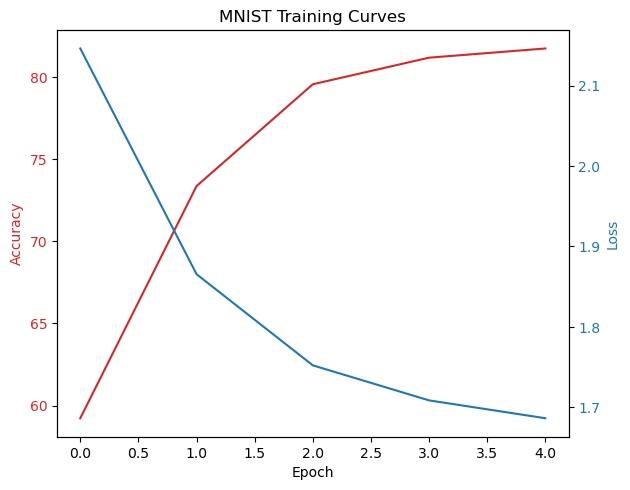

In [25]:
# Fonction pour initialiser le modèle, la perte et l'optimiseur
def init_model(nx, nh, ny, eta):
    model = nn.Sequential(
        nn.Linear(nx, nh),
        nn.Tanh(),
        nn.Linear(nh, ny),
        nn.Softmax(dim=1)
    )

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=eta)

    return model, loss_fn, optimizer

# Fonction pour calculer la perte et la précision
def loss_accuracy(model, loss, X, Y):
    Yhat = model(X)
    L = loss(Yhat, Y.squeeze().long())  # Squeeze pour enlever la dimension supplémentaire et long() pour convertir en int
    _, indsYhat = torch.max(Yhat, 1)
    acc = torch.sum(Y.squeeze().long() == indsYhat).item() / len(Y)

    return L, acc


# Chargement des données MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

# Chargement des données avec des DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

# Paramètres d'entraînement
nx = 28 * 28  # Dimension de l'image MNIST
nh = 100
ny = 10  # Nombre de classes dans MNIST (0-9)
eta = 0.03

# Initialisation du modèle, de la perte et de l'optimiseur
model, loss_fn, optimizer = init_model(nx, nh, ny, eta)

# Listes pour stocker les courbes d'apprentissage
curves = [[], []]

# Entraînement
for epoch in range(5):  # Choisissez le nombre d'époques souhaité
    for batch in train_loader:
        X, Y = batch

        # Reshape X pour s'adapter au modèle
        X = X.view(-1, 28 * 28)

        # Forward pass
        Yhat = model(X)

        # Calcul de la perte et de la précision
        loss, _ = loss_accuracy(model, loss_fn, X, Y)

        # Rétropropagation
        optimizer.zero_grad()
        loss.backward()

        # Optimisation
        optimizer.step()

    # Évaluation sur l'ensemble de test après chaque époque
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for batch in test_loader:
            X, Y = batch

            # Reshape X pour s'adapter au modèle
            X = X.view(-1, 28 * 28)

            loss, acc = loss_accuracy(model, loss_fn, X, Y)
            total_loss += loss.item()
            total_acc += acc

    avg_loss = total_loss / len(test_loader)
    avg_acc = total_acc / len(test_loader)

    # Affichage des résultats d'évaluation
    print(f'Epoch {epoch+1}/{5}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2%}')

    # Ajout des résultats aux courbes
    curves[0].append(avg_acc * 100)
    curves[1].append(avg_loss)
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(curves[0], label="Accuracy", color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(curves[1], label="Loss", color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('MNIST Training Curves')
plt.show()
